https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/assignments_fall2018/assignment4_websites_logistic_regression.ipynb

In [1]:
# Import libraries and set desired options
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# Read the training and test data sets, change paths if needed
train_df = pd.read_csv('data/train_sessions.csv', index_col='session_id')
test_df = pd.read_csv('data/test_sessions.csv', index_col='session_id')

# Convert time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [3]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(r"data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu



4.1. What are the dimensions of the training and test sets (in exactly this order)?
For discussions, please stick to ODS Slack, channel #mlcourse_ai, pinned thread #a4_q1

(82797, 20) and (253561, 20)

(82797, 20) and (253561, 21)

(253561, 21) and (82797, 20)

(253561, 20) and (82797, 20)

In [4]:
print(train_df.shape, test_df.shape)

(253561, 21) (82797, 20)


In [5]:
# Top websites in the training data set
top_sites = pd.Series(train_df[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.loc[top_sites.drop(0).index]

21     123776
0      122730
23      87619
782     77055
22      58258
dtype: int64


,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com


4.2. What kind of websites does Alice visit the most?
For discussions, please stick to ODS Slack, channel #mlcourse_ai, pinned thread #a4_q2


videohostings

social networks

torrent trackers

news

In [6]:
# Top websites for Alice in the training data set
top_sites = pd.Series(train_df[(train_df.target==1)][sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(5)
print(top_sites)
sites_dict.loc[top_sites.index]

77    1382
80    1354
76    1307
29     897
21     857
dtype: int64


,site
77,i1.ytimg.com
80,s.youtube.com
76,www.youtube.com
29,www.facebook.com
21,www.google.fr


In [7]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)
time_df['target'] = train_df['target']

# Find sessions' starting and ending
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)

# Calculate sessions' duration in seconds
time_df['seconds'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

time_df[time_df.target==1].head()

,target,min,max,seconds
session_id,,,,
251175,1,2013-02-12 16:25:10,2013-02-12 16:32:27,437.0
196388,1,2013-02-12 16:32:27,2013-02-12 16:32:53,26.0
172448,1,2013-02-12 16:32:53,2013-02-12 16:33:46,53.0
70129,1,2013-02-12 16:33:50,2013-02-12 16:33:53,3.0
206254,1,2013-02-12 16:33:55,2013-02-12 16:34:25,30.0


In [8]:
time_df.groupby('target').describe()
# Question 3
# for others, on average, Alice's session is shorter than that of other users - YES
# more than 1% of all sessions in the dataset belong to Alice - NO
# minimum and maximum durations of Alice's and other users' sessions are approximately the same - YES
# variation about the mean session duration for all users (including Alice) is approximately the same - No
# less than a quarter of Alice's sessions are greater than or equal to 40 seconds - Yes

seconds                                                       
           count        mean         std  min  25%   50%    75%     max
target                                                                 
0       251264.0  139.282372  296.653518  0.0  7.0  28.0  114.0  1800.0
1         2297.0   52.296474  153.309014  0.0  4.0  11.0   38.0  1763.0

In [9]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [10]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

# For the very basic model, we will use only the visited websites in the session 
# (but we will not take into account timestamp features). 
# The point behind this data selection is: Alice has her favorite sites, 
# and the more often you see these sites in the session, the higher probability that this is Alice's session, and vice versa.

# Let us prepare the data, we will take only features site1, site2, ... , site10 from the whole dataframe. 
# Keep in mind that the missing values are replaced with zero. Here is how the first rows of the dataframe look like:

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [11]:
# sequence of indices
sites_flatten = full_sites.values.flatten() # all sites in one row

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]


#csr_matrix((data, indices, indptr), [shape=(M, N)])
#is the standard CSR representation where the column indices 
#for row i are stored in indices[indptr[i]:indptr[i+1]] and 
#their corresponding values are stored in data[indptr[i]:indptr[i+1]]. 
#If the shape parameter is not supplied, the matrix dimensions are inferred from the index arrays.

In [12]:
full_sites_sparse

<336358x48371 sparse matrix of type '<class 'numpy.int32'>'
	with 3195430 stored elements in Compressed Sparse Row format>

In [13]:
sites_flatten.shape

(3363580,)

In [14]:
# csr_matrix is a frequency table  in the end per row
# how csr_matrix works
indptr = range(0, sites_flatten.shape[0]  + 10, 10)
data = [1] * sites_flatten.shape[0]
indices = sites_flatten


i = 0
for i in range(10):
    print("i", i, "data", data[indptr[i]:indptr[i+1]], "index", indices[indptr[i]:indptr[i+1]])
#    result[indices[indptr[i]:indptr[i+1]]] = data[indptr[i]:indptr[i+1]]
#    result [0, ... 55,56... максимальный айди из сайтов] = [1,1] 

i 0 data [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] index [56 55  0  0  0  0  0  0  0  0]
i 1 data [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] index [56 55 56 55  0  0  0  0  0  0]
i 2 data [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] index [946 946 951 946 946 945 948 784 949 946]
i 3 data [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] index [945 948 949 948 945 946 947 945 946 946]
i 4 data [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] index [947 950 948 947 950 952 946 951 946 947]
i 5 data [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] index [952 947 953 946 947 946 953 955 946 947]
i 6 data [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] index [ 953  947  946  953  955  947  953  946  953 1033]
i 7 data [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] index [946 947 954 953 946 954 946 956 957 956]
i 8 data [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] index [946 956 946 946 955 954 946 946 946 948]
i 9 data [1, 1, 1, 1, 1, 1, 1, 1, 1, 1] index [948 946 948 784  49  53 812 982  52  52]


In [15]:
# How much memory does a sparse matrix occupy?
print('{0} elements * {1} bytes = {2} bytes'.format(full_sites_sparse.count_nonzero(), 8, 
                                                    full_sites_sparse.count_nonzero() * 8))
# Or just like this:
print('sparse_matrix_size = {0} bytes'.format(full_sites_sparse.data.nbytes))

1866898 elements * 8 bytes = 14935184 bytes
sparse_matrix_size = 7467592 bytes


In [16]:
data = [1] * 9
indices = [1, 0, 0, 1, 3, 1, 2, 3, 4]
indptr = [0, 3, 6, 9]
ex_matrix = csr_matrix((data, indices, indptr)).todense()

conv = pd.DataFrame(ex_matrix)
conv.drop(0, axis=1)


,1,2,3,4
0,1,0,0,0
1,2,0,1,0
2,0,1,1,1


In [17]:
# 4.4. What is the sparseness of the matrix in our small example?
#  Such a matrix, where most elements are zeros, is called sparse, and the ratio 
# between the number of zero elements and the total number of elements is called the sparseness of the matrix.

data = conv.values.flatten()

len(data[data==0]) / len(data) * 100

53.333333333333336

In [18]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [19]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9195244077552184
Wall time: 13.1 s


In [20]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [21]:
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'data/baseline_1.csv')

In [22]:
#4.5. What years are present in the training and test datasets, if united?
    
dates= full_df[times].stack().reset_index().drop(["session_id", "level_1"], axis = 1)
dates

dates[0].dt.year.value_counts()

2014    2489523
2013     705907
Name: 0, dtype: int64

In [23]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_new_feat['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')

In [24]:
full_new_feat.head()

,start_month
session_id,
21669,201301.0
54843,201301.0
77292,201301.0
114021,201301.0
146670,201301.0


In [25]:
full_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,945,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,946,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,952,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22


In [26]:
time_df['start_month1'] = time_df['min'].apply(lambda ts: 
                                                      100 * ts.year + ts.month).astype('float64')
time_df.head()

,target,min,max,seconds,start_month1
session_id,,,,,
21669,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0,201301.0
54843,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0,201301.0
77292,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0,201301.0
114021,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0,201301.0
146670,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0,201301.0


In [27]:

graf = time_df[time_df.target==1].groupby("start_month1")['target'].count()
graf

start_month1
201302.0     61
201304.0     38
201309.0    377
201311.0    446
201312.0    134
201401.0    129
201402.0    410
201403.0    400
201404.0    302
Name: target, dtype: int64

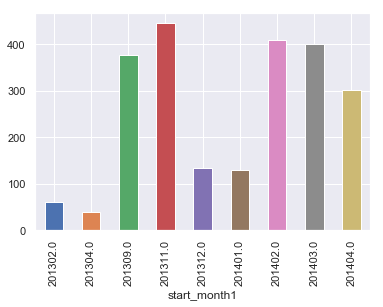

In [28]:
ax = graf.plot.bar()

In [29]:

# Add the new feature to the sparse matrix
tmp = full_new_feat[['start_month']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]])) 
# приделали значения годмесяц как еще одну колонку к матрице (253561, 48371) и (253561,1)
# hstack - Stack arrays in sequence horizontally (column wise).

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.7508354860175162


In [30]:
tmp[:idx_split,:]

array([[201301.],
       [201301.],
       [201301.],
       ...,
       [201404.],
       [201404.],
       [201404.]])

In [31]:
# Add the new standardized feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))



In [32]:
# for every x (x - mean)/std

# Compute metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9196986151568289


In [33]:
unique_sites_feat = pd.DataFrame(index=full_df.index)
unique_sites_feat['unique_sites'] = full_df[sites].nunique(axis=1)
unique_sites_feat.head()

,unique_sites
session_id,
21669,3
54843,3
77292,6
114021,5
146670,6


In [34]:
# Add the new feature to the sparse matrix
tmp_unique = unique_sites_feat[['unique_sites']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], tmp_unique[:idx_split,:] ])) 

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.916346934191267


In [35]:
tmp_unique = StandardScaler().fit_transform(unique_sites_feat[['unique_sites']].astype('float64'))
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], tmp_unique[:idx_split,:] ])) 

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9156858820147916


In [36]:
hours_feat = pd.DataFrame(index=full_df.index)
hours_feat['hour'] = full_df['time1'].apply(lambda ts: ts.hour) 
hours_feat.head()

,hour
session_id,
21669,8
54843,8
77292,8
114021,8
146670,8


In [37]:
morning_feat = pd.DataFrame(index=full_df.index)

bins = [0, 11, 24]
# Create names for the four groups
group_names = [1, 0]

morning_feat["morning"] = pd.cut(hours_feat['hour'], bins, labels=group_names)

In [38]:
# Add the new feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
hours = hours_feat[['hour']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], hours[:idx_split,:] ])) 

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9572750309165303


In [39]:
print(X_train[1, :].toarray())

[[ 0.          0.          0.         ...  0.         -2.07907592
   8.        ]]


In [40]:
# Add the new feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
morning = morning_feat[['morning']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], morning[:idx_split,:] ])) 

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.948667011458439


In [41]:
# Add the new feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
hours = hours_feat[['hour']].values
morning = morning_feat[['morning']].values
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], hours[:idx_split,:], morning[:idx_split,:]  ])) 

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.958495690404765


In [42]:
print(X_train[1, :].toarray())

[[ 0.          0.          0.         ... -2.07907592  8.
   1.        ]]


In [43]:
# Add the new feature to the sparse matrix
tmp = StandardScaler().fit_transform(full_new_feat[['start_month']])
hours = StandardScaler().fit_transform(hours_feat[['hour']].astype('float64')) 
morning = StandardScaler().fit_transform(morning_feat[['morning']].astype('float64')) 
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:], hours[:idx_split,:], morning[:idx_split,:]  ])) 

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9591502513175756


In [44]:
# тоже самое что и в моем блоке
# Compose the training set
full_new_feat['start_hour'] = hours_feat['hour'].astype('float64')
full_new_feat['morning'] = morning_feat['morning'].astype('float64')
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 
                                                           'start_hour', 
                                                           'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp_scaled[:idx_split,:]]))

# Capture the quality with default parameters
score_C_1 = get_auc_lr_valid(X_train, y_train)
print(score_C_1)

0.9591502513175756


In [45]:
from tqdm import tqdm

# List of possible C-values
Cs = np.logspace(-3, 1, 10)
scores = []
for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))

100%|██████████████████████████████████████████| 10/10 [01:25<00:00, 16.29s/it]


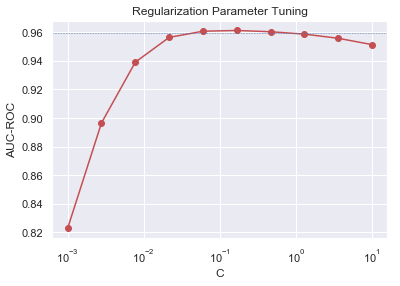

In [46]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Regularization Parameter Tuning')
# horizontal line -- model quality with default C value
plt.axhline(y=score_C_1, linewidth=.5, color='b', linestyle='dashed') 
plt.show()

In [47]:
max_scores=max(scores)
[i for i, j in enumerate(scores) if j == max_scores]
Cs[5] # 0.1668100537200059

0.1668100537200059

In [48]:
# Prepare the training and test data
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 
                                                           'morning']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=0.17, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the submission file
write_to_submission_file(y_test, 'baseline_2.csv')

In [52]:
#X_add['duration'] = (full_df['time10'] - full_df['time1']).astype(int).apply(lambda x: x/10e8)

duration_feat = pd.DataFrame(index=full_df.index)
# Find sessions' starting and ending
duration_feat['min'] = full_df[times].min(axis=1)
duration_feat['max'] = full_df[times].max(axis=1)


duration_feat['duration'] =  (duration_feat['max'] - duration_feat['min']) / np.timedelta64(1, 's')
duration_feat.head()

,min,max,duration
session_id,,,
21669,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54843,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77292,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114021,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146670,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0


In [55]:
full_new_feat['duration'] = duration_feat['duration'].astype('float64')
full_new_feat.head()

(336358, 4)

In [57]:
# Add the new feature to the sparse matrix
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 
                                                           'morning', 'duration']])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp_scaled[:idx_split,:]])) 

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9591785562463467


In [65]:
day_feat = pd.DataFrame(index=full_df.index)

bins = [0, 6, 11, 18, 23]
# Create names for the four groups
group_names = [0, 1, 2, 3]

day_feat["day_type"] = pd.cut(hours_feat['hour'], bins, labels=group_names)
day_feat = pd.get_dummies(day_feat, prefix=['type'], columns=["day_type"]) 
day_feat.head()

,type_0,type_1,type_2,type_3
session_id,,,,
21669,0,1,0,0
54843,0,1,0,0
77292,0,1,0,0
114021,0,1,0,0
146670,0,1,0,0


In [87]:
tmp_scaled = StandardScaler().fit_transform(full_new_feat[['start_month', 'start_hour', 'duration']])

day_types = StandardScaler().fit_transform(day_feat[['type_0','type_1','type_2','type_3']].astype('float64'))
#day_types = day_feat[['type_0','type_1','type_2','type_3']].values

X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp_scaled[:idx_split,:], day_types[:idx_split,:] ])) 

# Compute the metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9683472397335382
